In [1]:
import pandas as pd
import numpy as np
import FundInfo as fi
import seaborn as sns
from matplotlib import pyplot as plt

Tickers Reference: https://www.tsx.com/listings/listing-with-us/sector-and-product-profiles/exchange-traded-funds

In [2]:
# read data
rootDir = "../"
#inputFileName = "tsx-et-fs-mi-g-list-2020-06-22-en.csv"
inputFileName = "sample_tickers.csv"

#tickers from tsx exchange need .TO as suffix
fundInfo = fi.FundCompositionMetrics(rootDir, inputFileName, ".TO", readLocal=False)

  0%|                                                                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

Reading ticker data from url: started


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:47<00:00,  5.87s/it]

Info file saved ....
Reading ticker data from url: done


In [5]:
fundInfoDF = fundInfo.allFundInfoDF
#data overview
print("Total tickers : %d "%len(fundInfoDF["symbol"]))
print("\nTotal Fund Families : %d "%len(fundInfoDF["profileFundFamily"].str.lower().unique()))
print("\nTicker by Fund Families : \n%s "%(fundInfoDF["profileFundFamily"].str.lower().value_counts()))

Total tickers : 100 

Total Fund Families : 25 

Ticker by Fund Families : 
n/a                                      21
ishares                                  16
horizons etfs management (canada) inc     8
bmo asset management inc                  8
vanguard investments canada inc           5
first asset investment management inc     5
td asset management inc                   4
rbc global asset management inc.          3
purpose investments inc.                  3
dgam                                      3
mackenzie financial corporation           3
ft portfolios canada co                   2
cibc asset management inc.(cami)          2
brompton funds limited                    2
manulife investments                      2
franklin advisory services, llc           2
evolve funds group inc.                   2
picton mahoney asset management           2
ci investments inc                        1
agf investments inc.                      1
national bank investments inc             1


In [7]:
(fundInfoDF.loc[fundInfoDF["previous_close"].isnull(), "symbol"])

Series([], Name: symbol, dtype: object)

In [16]:
selectedColumns = ["symbol", "profileFundFamily", "previous_close", "stocks", "bonds",
                   "priceearnings", "pricebook", "pricesales", "pricecashflow"]
dataDF = fundInfoDF.loc[:, selectedColumns]
dataDF = dataDF.dropna(subset=['previous_close'])
dataDF = dataDF.drop(dataDF[(dataDF["stocks"] == "TOR") 
                            | (dataDF["stocks"] == "N/A")
                            | (dataDF["bonds"] == "N/A")].index)

In [30]:
dataDF["profileFundFamily"] = dataDF["profileFundFamily"].str.lower()
dataDF[["stocks", "bonds"]] = dataDF[["stocks", "bonds"]].replace("%", "", regex=True).astype(float)
dataDF[selectedColumns[2:]] = dataDF[selectedColumns[2:]].astype(float)
dataDF

,symbol,profileFundFamily,previous_close,stocks,bonds,priceearnings,pricebook,pricesales,pricecashflow
1,ESG,invesco canada ltd.,22.58,82.29,0.00,22.39,3.40,2.30,14.44
2,FLCD,"franklin advisory services, llc",20.92,99.98,0.00,14.75,1.59,1.38,7.64
3,XBAL,ishares,24.31,59.10,38.07,18.25,1.99,1.43,10.15
4,VE,vanguard investments canada inc,27.78,99.82,0.00,16.99,1.50,1.01,8.52
5,FLRM,franklin templeton investments corp,20.11,95.74,0.00,14.09,1.61,1.47,9.07
...,...,...,...,...,...,...,...,...,...
93,HTB,horizons etfs management (canada) inc,65.95,0.00,100.00,0.00,0.00,0.00,0.00
96,CARS,evolve funds group inc.,29.82,63.98,0.00,17.10,2.89,1.37,8.91
97,ZFS,bmo asset management inc,14.64,0.00,99.94,0.00,0.00,0.00,0.00
98,ZFM,bmo asset management inc,17.64,0.00,99.91,0.00,0.00,0.00,0.00


Text(0.5, 1.0, 'Fund Composition')

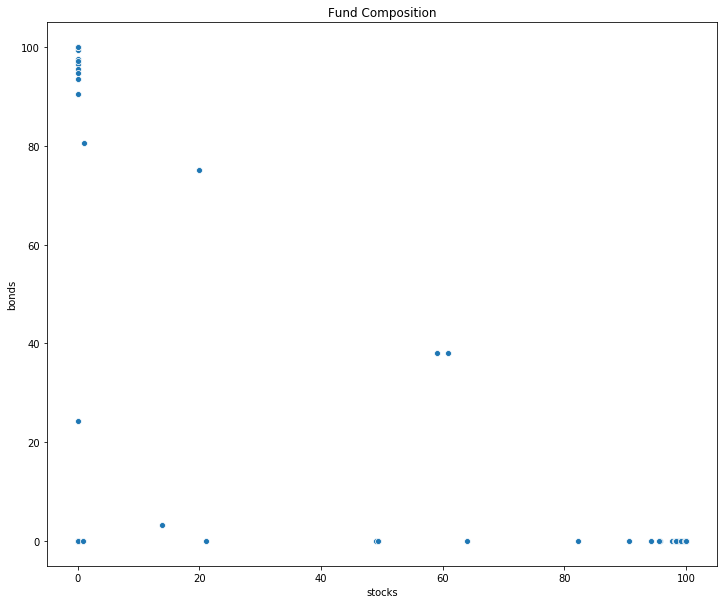

In [24]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.scatterplot(data=dataDF, x="stocks", y="bonds", ax=ax)
ax.set_title("Fund Composition")


Text(0.5, 1.0, 'Ratios')

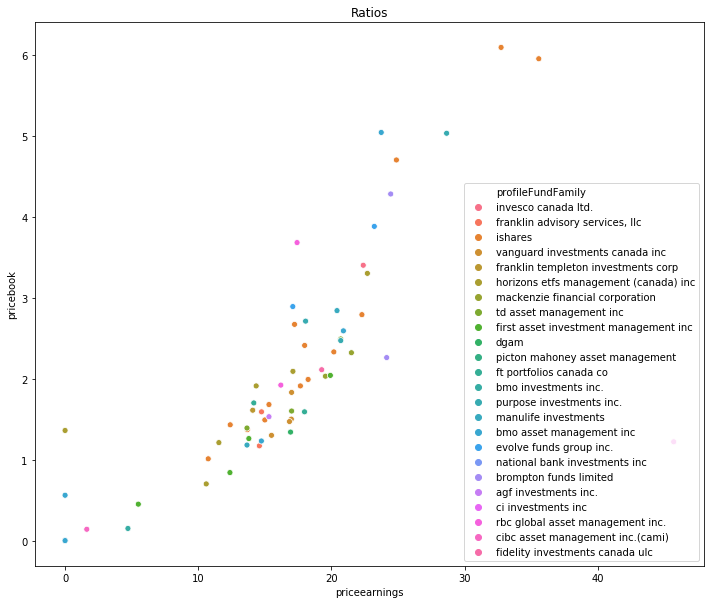

In [26]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.scatterplot(data=dataDF, x="priceearnings", y="pricebook", hue="profileFundFamily", ax=ax)
ax.set_title("Ratios")


In [27]:
from sklearn.cluster import KMeans

trainData = dataDF[["stocks", "bonds"]].dropna()

clusterNames = ["Equity", "FixedIncome", "Commodity", "Balanced"]

clusters = KMeans(n_clusters=4, random_state=0).fit(trainData)

trainData["asset_type"] = [clusterNames[label] for label in clusters.labels_]

centroids = clusters.cluster_centers_
print(centroids)

[[9.8485625e+01 6.2500000e-04]
 [1.3960000e+00 9.4654000e+01]
 [3.5680000e+00 2.7490000e+00]
 [5.5265000e+01 1.2695000e+01]]


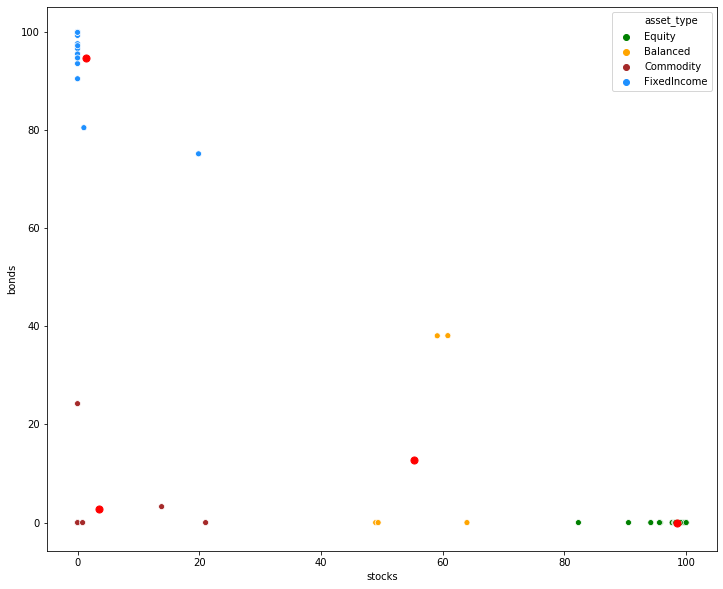

In [28]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.scatterplot(data=trainData, x="stocks", y="bonds", hue="asset_type", ax=ax, palette=['green','orange','brown','dodgerblue'])
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)


In [29]:
trainData.groupby("asset_type").count()

,stocks,bonds
asset_type,,
Balanced,6,6
Commodity,10,10
Equity,48,48
FixedIncome,15,15
